# Introduction
> **GOAL: Develop a machine learning model to predict the source of a data packet.**

In this section we develop learning model(s) for our device identification problem. We load the dataset from feather files that we saved in the Data Wrangling section.

In [19]:
%matplotlib inline

import numpy as np  
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [3]:
EXTRACTED_PCAP_PATH = './feathers/16-09-23.pcap.feather'
df = pd.read_feather(EXTRACTED_PCAP_PATH)

# Data Exploration
I this section we explore the data columns further and end up removing ten more columns further.

In [4]:
df.shape

(947072, 60)

In [4]:
low_unique_value_columns = df[df.columns].nunique()/(df ==0).sum()

In [5]:
low_unique_value_columns.sort_values()[:20]

ip.dsfield.ecn              0.000001
ip.flags.rb                 0.000001
ip.flags.mf                 0.000002
tcp.flags.reset             0.000002
tcp.flags.fin               0.000002
tcp.flags.syn               0.000002
tcp.flags.push              0.000003
ip.frag_offset              0.000003
tcp.analysis.initial_rtt    0.000005
frame.time_delta            0.000005
tcp.flags.ack               0.000008
tcp.checksum.status         0.000008
ip.dsfield.dscp             0.000008
ip.dsfield                  0.000008
ip.flags.df                 0.000011
ip.checksum.status          0.000018
ip.flags                    0.000021
tcp.analysis.ack_rtt        0.000023
ip.hdr_len                  0.000027
ip.version                  0.000042
dtype: float64

In [6]:
# Thus, we decide to further delete these columns as well.

cols_to_drop = ["ip.flags.rb","ip.dsfield.ecn","ip.flags.mf",
                "tcp.flags.reset","tcp.flags.fin","tcp.flags.syn",
                "tcp.flags.push","ip.frag_offset","tcp.flags.ack",
                "tcp.checksum.status"]

In [7]:
df.drop(columns=cols_to_drop, inplace=True)
df.shape

(947072, 50)

# Testing out Learning Models- I

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [9]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(['eth.src'])], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [10]:
assert y_train.nunique() >= y_test.nunique(), \
                    "WARN: This means that some classes\
                    are not present in the training set but\
                    are present in the test set"

In [9]:
RF = RandomForestClassifier(n_estimators=20)

In [43]:
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
res = RF.predict(X_test)
accuracy_score(y_test, res, normalize=True)

0.986458305836391

### Discussion
Upon realizing the >0.99 accuracy, we plan to make the learning problem a bit more difficult by removing certain columns which are highly correlated with the target label i.e. `eth.src`

In [14]:
df.corr()['eth.src'].sort_values()

tcp.dstport                    -0.376963
tcp.time_relative              -0.298453
eth.dst                        -0.257750
ip.id                          -0.230737
ip.len                         -0.217475
tcp.nxtseq                     -0.213376
tcp.seq                        -0.213371
frame.len                      -0.201500
tcp.len                        -0.198343
tcp.hdr_len                    -0.183476
tcp.window_size_scalefactor    -0.176216
tcp.analysis.bytes_in_flight   -0.171085
eth.dst.oui                    -0.152728
tcp.analysis.push_bytes_sent   -0.115878
ip.flags.df                    -0.111405
ip.flags                       -0.111288
udp.dstport                    -0.085241
tcp.segment                    -0.080609
tcp.segment.count              -0.048333
tcp.reassembled.length         -0.045555
ip.checksum.status             -0.039895
ip.hdr_len                     -0.039051
frame.time_delta               -0.017092
udp.length                     -0.011317
ip.dsfield.dscp 

In [7]:
columns_to_hide = ['eth.src', 
                   'eth.dst', 
                   'ip.src', 
                   'ip.dst',
                   'eth.src.oui',
                   'eth.dst.oui',
                   'frame.time_epoch']

In [8]:
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(columns_to_hide)], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [10]:
RF = RandomForestClassifier(n_estimators=20)

RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
res = RF.predict(X_test)
accuracy_score(y_test, res, normalize=True)

0.9329618966500306

In [12]:
print("Total number of devices = {devices}".format(devices=df['eth.src'].nunique()))
print("Total number of rows = {rows}".format(rows=df.index.size))

Total number of devices = 22
Total number of rows = 947072


### Summary and Discussion
We realize that we are able to get an accuracy of 99% with all the columns, and an accuracy of 93% when the columns with strong correlation with the target label (`eth.src`) are removed.


## Finding important features

So far, we have been using 50 features which we decided to be most usefule based on certain heuristics. However, since our eventual dataset so so large that we need to find not only an performant model, but also a model that may scale well with the large data size that we have. In this section we find the most 'informative' columns.

In [18]:
feature_importance = sorted(zip(X_train.columns, RF.feature_importances_), 
                       key=lambda x: x[-1], 
                       reverse=True)

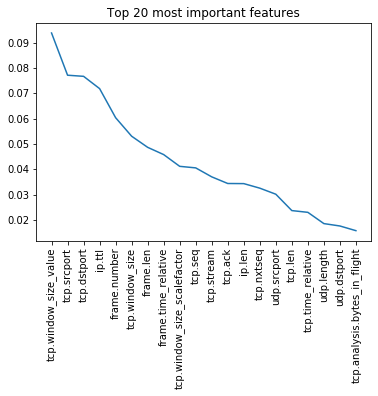

In [27]:
plt.xticks(rotation=90)
plt.title("Top 20 most important features")

plt.plot([_[0] for _ in feature_importance[:20]],
         [_[1] for _ in feature_importance[:20]])

# Finding Best Models 
In this section, we try to pick up models that would perform the best on our dataset.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from datetime import datetime

In [47]:
models = [{"name": "k-Nearest Neighbor",
        "model": KNeighborsClassifier,
        "time_taken": "",},
        {"name": "Random Forest Classifier",
        "model": RandomForestClassifier,
        "time_taken": ""}]

In [36]:
if len(df.columns) > 20:
    print("You've too many features. Check section 3.1 and lower number of features")

You've too many features. Check section 3.1 and lower number of features


In [39]:
cols_to_use = [_[0] for _ in feature_importance[:20]]+['eth.src']

In [41]:
df.drop(columns=[_ for _ in df.columns if _ not in cols_to_use], inplace=True)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(['eth.src'])], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [53]:
for model in models:
    time = datetime.now()
    params = model.get('params', None)
    if params:
        model["model"] = model["model"](**params)
    else:
        model["model"] = model["model"]()
        
    print("\n\n-> Training model: ", model["model"])
    
    model["model"].fit(X_train, y_train)
    model["time_taken"] = datetime.now()-time
    
    print("->> Time taken ", model["time_taken"])
    
    print("Model is ", model['name'])
    print(accuracy_score(y_test, model['model'].predict(X_test)))



-> Training model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
->> Time taken  0:03:15.577460
Model is  k-Nearest Neighbor
0.9146423015465187


-> Training model:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
->> Time taken  0:03:33.541119
Model is  Random Forest Classifier
0.9152934302869894


## Check over-under fitting classes
In this step we confirm that our choice of classifier won't overfit and underfit for certain classes.


Model Name: k-Nearest Neighbor


<Figure size 4500x4500 with 0 Axes>

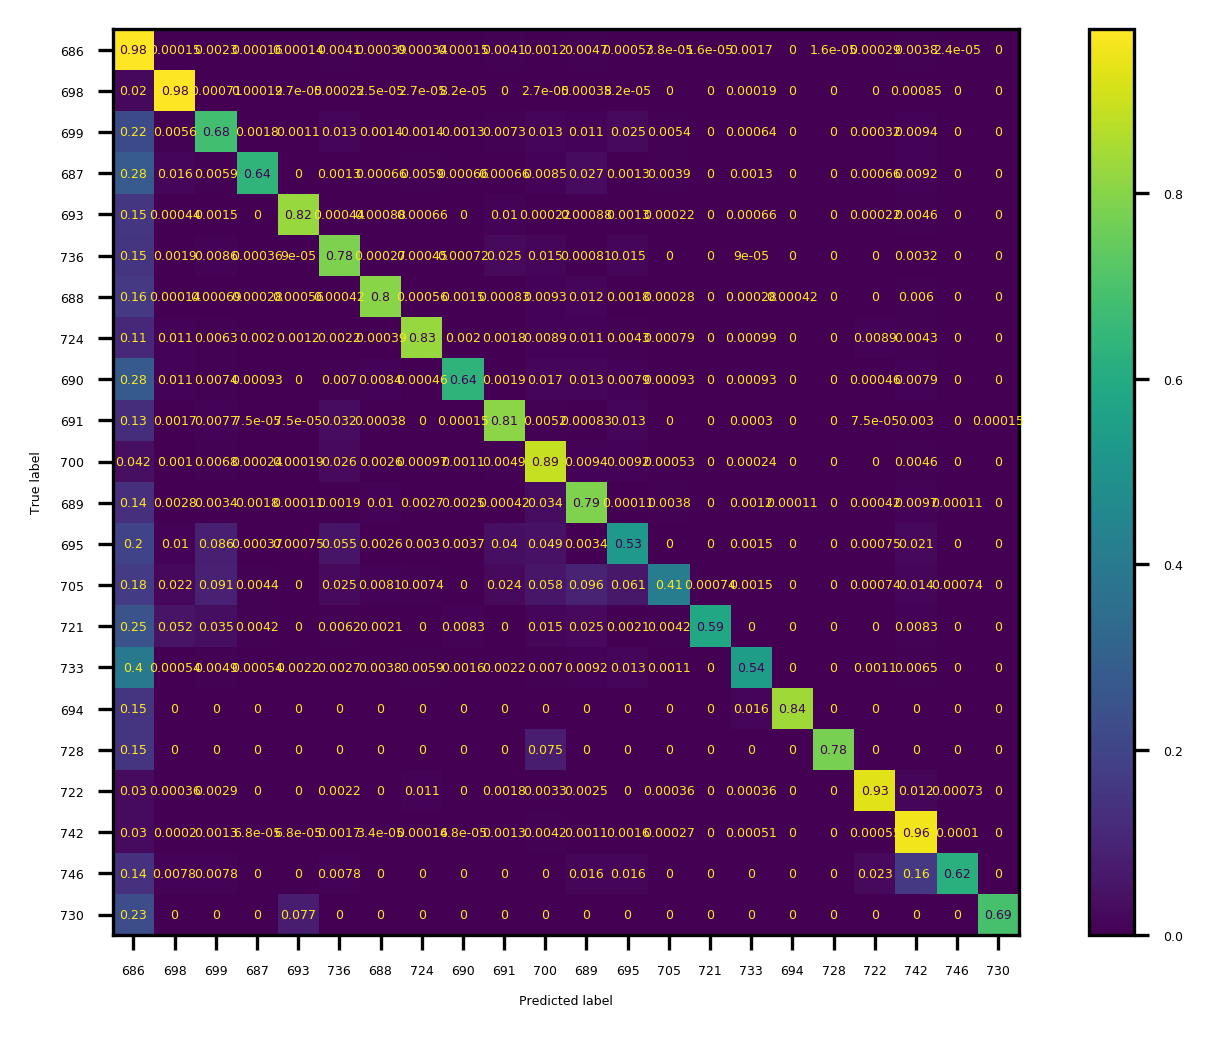

Model Name: Random Forest Classifier


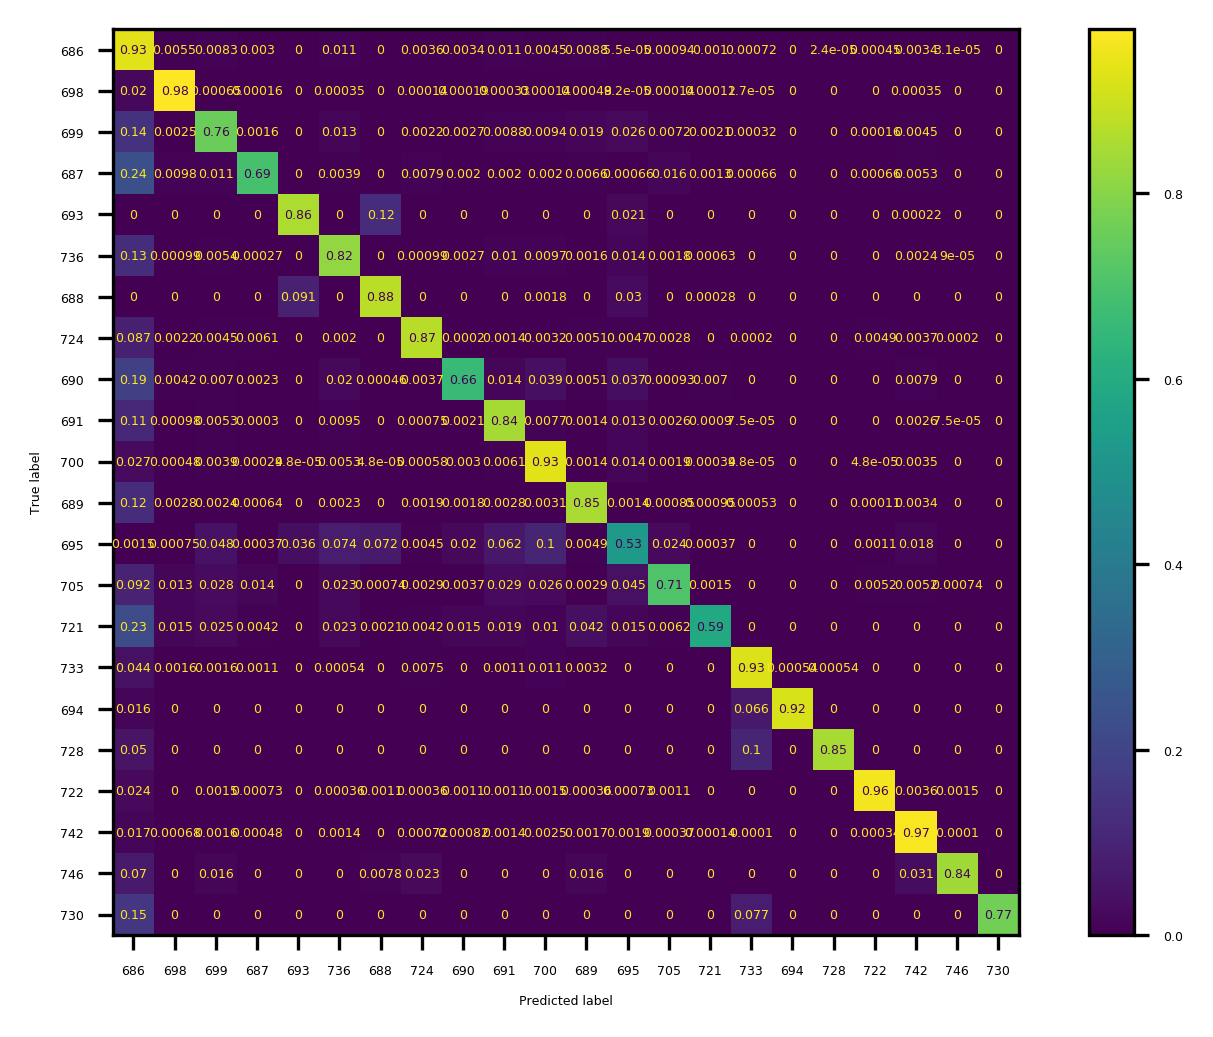

In [64]:
%matplotlib inline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 3})
    
for model in models:
    print("Model Name: "+ model['name'])
    plot_confusion_matrix(model['model'], 
                          X_test, 
                          y_test,
                          display_labels=y_test.unique(),
                          normalize='true')
    plt.show()

In [78]:
from sklearn.metrics import classification_report, f1_score

In [74]:
for model in models:
    print(model['name'])
    preds = model['model'].predict(X_test)
    print(classification_report(y_test, 
                                preds,
                               output_dict=False))
    
    print('\n\n\n')

k-Nearest Neighbor
              precision    recall  f1-score   support

         686       0.90      0.98      0.94    127522
         687       0.99      0.98      0.98     36653
         688       0.78      0.68      0.73      6278
         689       0.91      0.64      0.75      1523
         690       0.99      0.82      0.90      4540
         691       0.82      0.78      0.80     11083
         693       0.96      0.80      0.87      7199
         694       0.96      0.83      0.89      5072
         695       0.91      0.64      0.75      2154
         698       0.90      0.81      0.85     13319
         699       0.93      0.89      0.91     20656
         700       0.85      0.79      0.82      9430
         705       0.59      0.53      0.56      2670
         721       0.82      0.41      0.55      1356
         722       0.99      0.59      0.74       481
         724       0.78      0.54      0.64      1855
         728       0.93      0.84      0.88        61
        

### Conclusion
From this rough and approximate report, we decide to further hone our Random Forest classifier as our final model, since RF can be improved further with feature engineering and hyperparameter tuning. From here on, we work with Random Forest only (with a base performance of avg accuracy: 93%

## Check hyper-parameter tuning


We assume the independence of `n_estimators` and `max_depth` for our purposes and find the optimal values. 

In [86]:
n_estimators = [20, 30, 40, 80, 120, 160]
accuracy, f1_scores = [], []


for each in n_estimators:
    print("Running with n_estimators= ", each)
    model = RandomForestClassifier(n_estimators=each)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds, normalize=True))
    f1_scores.append(f1_score(y_test, preds, average='macro'))


Running with n_estimators=  20
Running with n_estimators=  30
Running with n_estimators=  40
Running with n_estimators=  80
Running with n_estimators=  120
Running with n_estimators=  160


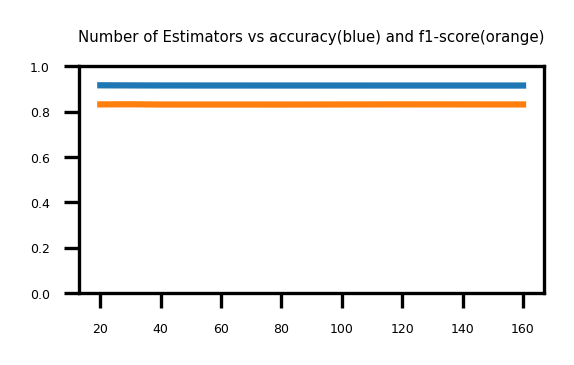

In [96]:
plt.figure(figsize=(2,1))
plt.ylim((0, 1))
plt.title('Number of Estimators vs accuracy(blue) and f1-score(orange)')
plt.plot(n_estimators, accuracy)
plt.plot(n_estimators, f1_scores)
plt.show()

The number of estimators don't seem to improve the accuracy (or f1-score either). We therefore proceed to use `n_estimators = 20`

In [102]:
tree_depths = [10, 15, 20, 30, 80, 100]
accuracy, f1_scores = [], []


for each in tree_depths:
    print("Running with max_depth= ", each)
    model = RandomForestClassifier(n_estimators=20, max_depth=each)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, preds, normalize=True))
    f1_scores.append(f1_score(y_test, preds, average='macro'))


Running with max_depth=  10
Running with max_depth=  15
Running with max_depth=  20
Running with max_depth=  30
Running with max_depth=  80
Running with max_depth=  100


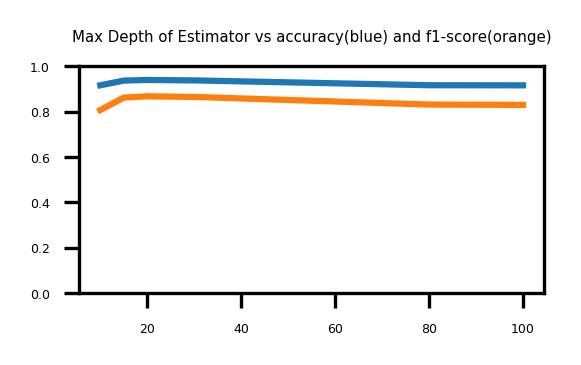

In [105]:
plt.figure(figsize=(2,1))
plt.ylim((0, 1))
plt.title('Max Depth of Estimator vs accuracy(blue) and f1-score(orange)')
plt.plot(tree_depths, accuracy)
plt.plot(tree_depths, f1_scores)
plt.show()

Increasing the `max_depth` don't seem to improve the accuracy (or f1-score either). We therefore proceed to use `max_depth = 20`

# Running, Testing and Interpreting the Best Model
> NOTE: This section is an independent section and is complete within itself. Only few global variables will have to be tweaked.


## Feature Engineering
In this section we explore the possibility of improving our models performance by augmenting the training set with featured engineered columns.

In [286]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

NUM_OF_PCAPS_TO_LOAD = 1
PATH_TO_EXTRACTED_TSVS = './extracted_pcaps/'
TEST_SIZE = 0.3

pcap_files = [PATH_TO_EXTRACTED_TSVS+_ for _ in os.listdir(PATH_TO_EXTRACTED_TSVS)]
pcap_files.sort()

assert len(pcap_files) >= NUM_OF_PCAPS_TO_LOAD, \
    "DATA: Only {} files to read".format(len(pcap_files))

"""
The following variables based upon previous sections/notebooks
"""
RANDOM_STATE = 3
N_ESTIMATORS = 20
MAX_DEPTH = 20

COLS_TO_CONSIDER = ['tcp.window_size_value',
                     'tcp.srcport',
                     'tcp.dstport',
                     'ip.ttl',
                     'frame.number',
                     'tcp.window_size',
                     'frame.len',
                     'frame.time_relative',
                     'tcp.window_size_scalefactor',
                     'tcp.seq',
                     'tcp.stream',
                     'tcp.ack',
                     'ip.len',
                     'tcp.nxtseq',
                     'udp.srcport',
                     'tcp.len',
                     'tcp.time_relative',
                     'udp.length',
                     'udp.dstport',
                     'tcp.analysis.bytes_in_flight',
                     'eth.src']

model = RandomForestClassifier(n_estimators=N_ESTIMATORS, 
                               max_depth=MAX_DEPTH,
                               random_state=RANDOM_STATE)

In [241]:
df = pd.concat(pd.read_csv(_,
                           usecols=COLS_TO_CONSIDER, 
                           sep='\t', 
                           low_memory=False) for _ in pcap_files)

In [242]:
ADDRESS_MAP = ['NaN']

def address_conversion(addr):
    global ADDRESS_MAP
    if addr in ADDRESS_MAP:
        return ADDRESS_MAP.index(addr)
    else:
        ADDRESS_MAP.append(addr)
        return len(ADDRESS_MAP)-1

In [243]:
#numbers of the kind floats, str+','+str
dirtynums_to_int = lambda col: pd.to_numeric(
                                col.fillna(value=0).apply(
                                    lambda _: int(_.split(',')[0]) if type(_) == str else int(_)),
                                downcast='unsigned')

float_to_int = lambda col: pd.to_numeric(
                            col.apply(
                                lambda _: int(_*1_000_000)), downcast='unsigned')
    


field_conversions = [{'col': 'ip.len', 'op': dirtynums_to_int},
                    {'col': 'ip.ttl', 'op': dirtynums_to_int},                   
                    {'col': 'tcp.srcport', 'op': dirtynums_to_int},
                    {'col': 'tcp.dstport', 'op': dirtynums_to_int},
                    {'col': 'tcp.time_relative', 'op': float_to_int},
                    {'col': 'frame.time_relative', 'op': float_to_int}]


df.fillna(value=0, inplace=True)

for conversion in field_conversions:
    df[conversion['col']] = conversion['op'](df[conversion['col']])


In [244]:
df['eth.src'] = df['eth.src'].apply(address_conversion)

In [245]:
for each in df.columns.difference([_['col'] for _ in field_conversions]):
    df[each] = pd.to_numeric(df[each], downcast='integer')

In [246]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns.difference(['eth.src'])], 
    df['eth.src'],
    test_size=TEST_SIZE)

In [288]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [289]:
accuracy_score(y_test, model.predict(X_test), normalize=True)

0.8680489082694209

In [285]:
model.oob_score_

0.9249067691741496

In [287]:
gc.collect()

7197